# Importing Libraries

In [1]:
#!pip install "dask[dataframe]"

In [2]:
#!pip install dtale
import dtale

In [3]:
#!pip install dataprep

In [4]:
#!pip install pandas-visual-analysis

In [5]:
#Installing Libraries

#!pip install dtale
#!pip install dataprep
#!pip install pandas-visual-analysis

# Import libraries




import warnings
import itertools
%matplotlib inline
import numpy as np
import pandas as pd

from math import sqrt
import seaborn as sns

import missingno as mn
import plotly.io as pio
sns.set_style('darkgrid')

from pandas import Grouper
import scipy.stats as stat
import plotly.express as px
from pandas import DataFrame

import statsmodels.api as smf
import pandas_profiling as pp
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
import plotly.figure_factory as ff

from pandas.plotting import lag_plot
import statsmodels.formula.api as sm
from plotly.offline import plot as off
from plotly.subplots import make_subplots

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.feature_selection import SelectKBest
from pandas_visual_analysis import VisualAnalysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES

from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
#from dataprep.eda import plot, plot_correlation, plot_missing, create_report

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale, RobustScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

# Exploring Dataset

In [6]:
data=pd.read_excel('CO2_dataset.xlsx',index_col='Year',parse_dates=True)

#data.set_index('Year', inplace=True)
data.index = pd.DatetimeIndex(data.index.values,freq=data.index.inferred_freq)
data.head()

,CO2
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [7]:
data.describe()

,CO2
count,215.000000
mean,6.741970
std,6.522437
min,0.001750
25%,0.041050
50%,6.390000
75%,11.500000
max,18.200000


# Spliting of Data

In [8]:
data.shape

(215, 1)

In [9]:
size = -20
train_data = data[:size]
test_data = data[size:]

In [10]:
test_data.describe()

,CO2
count,20.000000
mean,16.375000
std,0.859544
min,14.700000
25%,15.825000
50%,16.650000
75%,16.925000
max,17.500000


In [11]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1800-01-01 00:00:00 1994-01-01 00:00:00 
 Test: 1995-01-01 00:00:00 2014-01-01 00:00:00


In [12]:
%matplotlib inline

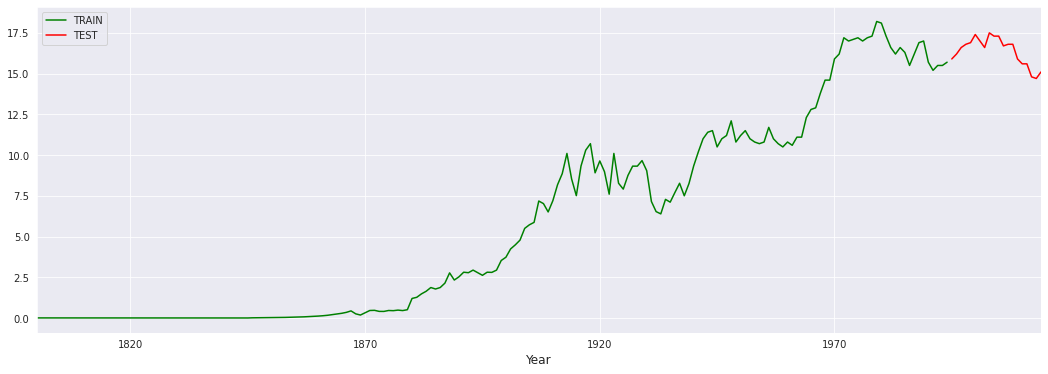

In [13]:
train_data.CO2.plot(legend=True,label='TRAIN',color='green')
test_data.CO2.plot(legend=True,label='TEST', figsize=(18,6),color='red')
plt.xlabel('Year', fontsize= 12)
plt.legend()
plt.show()

# MAPE Function

In [14]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Test For if data is Stationary or not 

In [15]:
%matplotlib inline

In [16]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(16,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['CO2'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(np.round(dfoutput,3))
    
    result = adfuller(timeseries.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")

# Converting Non-Stationary Time Series into Stationary

In [17]:
%matplotlib inline

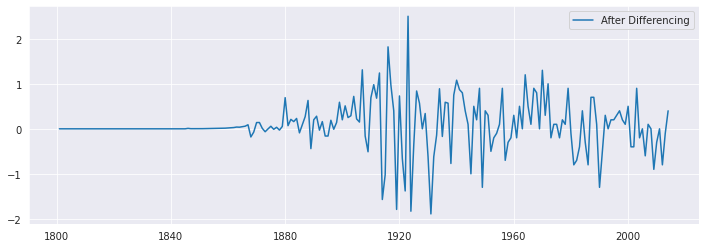

In [18]:
differencing = data - data.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

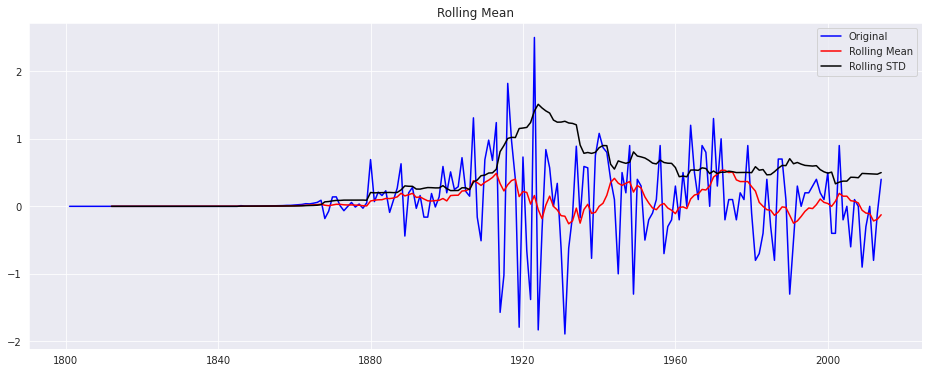

Results of Dickey Fuller Test:
Test Statistic                  -3.780
p-value                          0.003
#Lags Used                      15.000
Number of Observations Used    198.000
Critical Value (1%)             -3.464
Critical Value (5%)             -2.876
Critical Value (10%)            -2.575
dtype: float64
Reject the null hypothesis
Data is stationary


In [19]:
test_stationarity(differencing)

# ARIMA Hyperparameter Tuning

In [20]:
import itertools

In [21]:
p = range(0,8)
q = range(0,8)
d = range(0,5)

In [22]:
pqd_combination = list(itertools.product(p,d,q))

In [23]:
len(pqd_combination)

320

In [24]:
rmse = []
order = []

In [25]:
for pdq in pqd_combination:
    try:
        model = ARIMA(train_data, order=pdq).fit()
        pred = model.forecast(20)
        error = np.sqrt(mean_squared_error(test_data,pred))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization fai

In [26]:
results = pd.DataFrame(index=order,data=rmse,columns=['RMSE'])
results.sort_values('RMSE')

,RMSE
"(4, 1, 4)",0.776831
"(2, 4, 5)",0.920554
"(2, 4, 6)",0.926155
"(1, 4, 4)",0.944294
"(3, 4, 6)",0.946561
...,...
"(1, 4, 0)",108.608669
"(4, 4, 0)",136.964210
"(5, 4, 0)",152.618023
"(2, 4, 0)",187.160320


# Model Building

In [27]:
model = ARIMA(train_data, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data.index.min(), data.index.max())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [28]:
%matplotlib inline

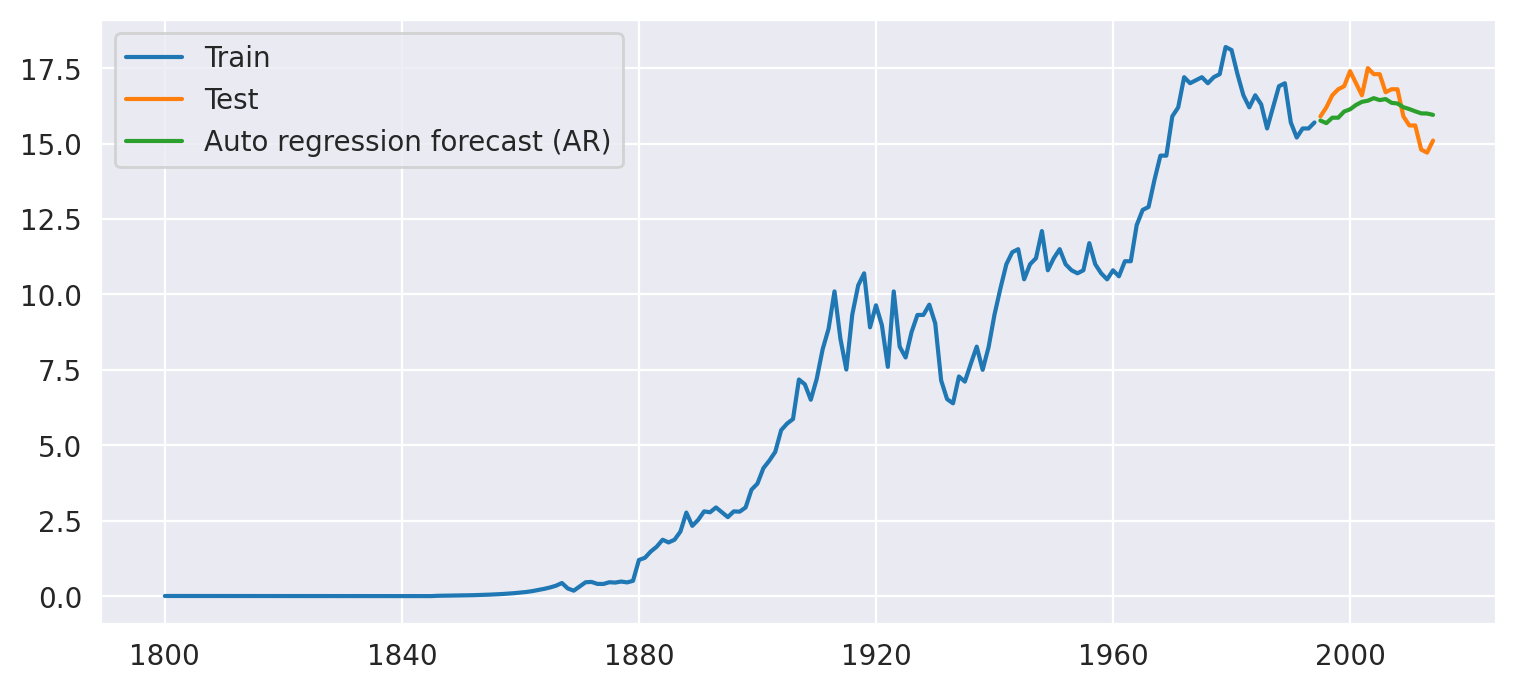

In [29]:
plt.figure(figsize=(9,4), dpi=200)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

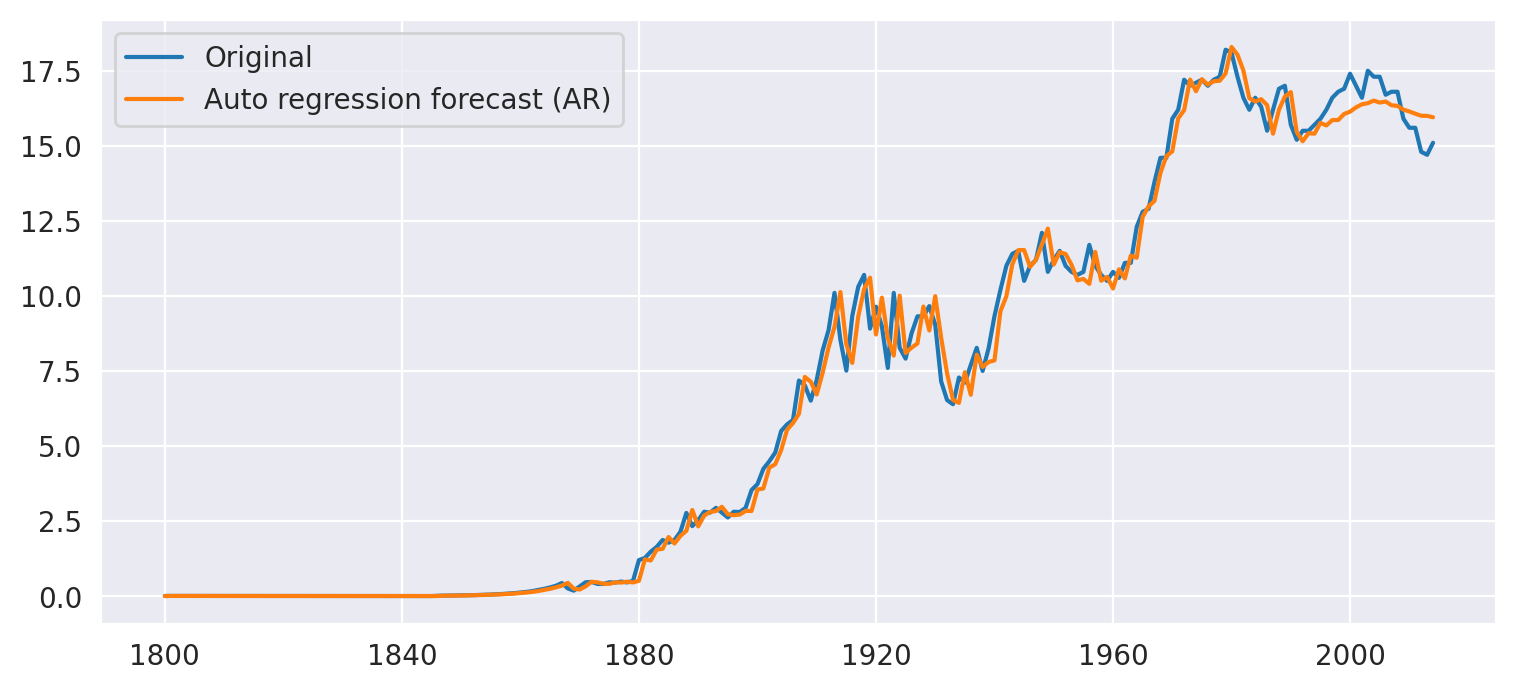

In [30]:
plt.figure(figsize=(9,4), dpi=200)
plt.plot(data['CO2'], label='Original')
plt.plot(y_hat_ar['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

# Model Evaluation

In [31]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

0.78

In [32]:
mape_arima = round(np.mean(np.abs((test_data.CO2 - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.CO2)*100),2)
mape_arima

4.28

In [33]:
model_residual = model_fit.resid
model_residual.mean()

0.06967503395938886

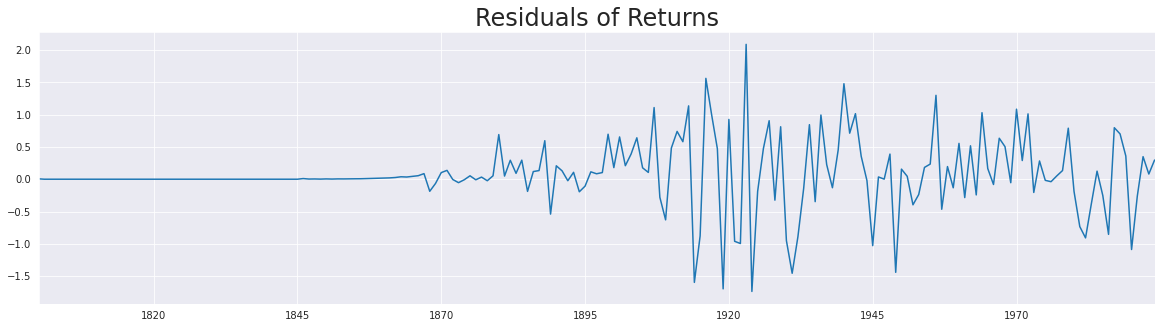

In [34]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

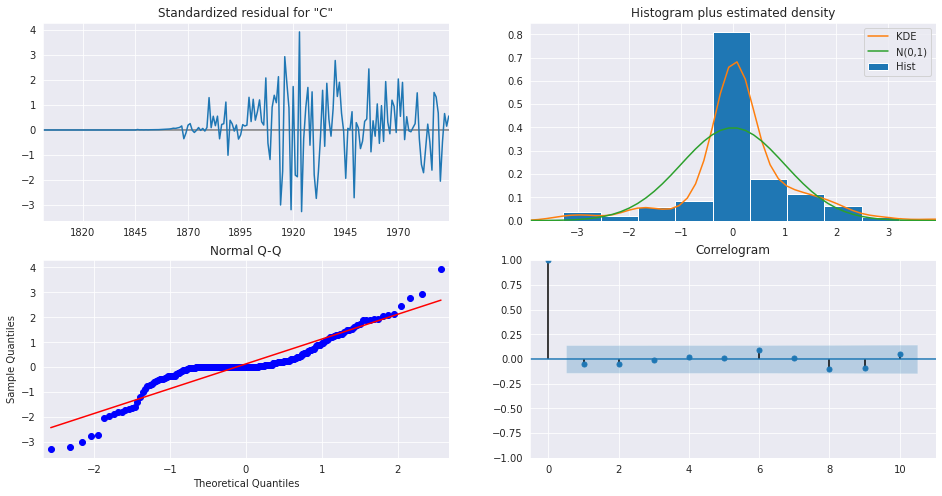

In [35]:
model_fit.plot_diagnostics(figsize=(16,8))
plt.show()

In [36]:
y_hat_ar[test_data.index.min():]

,CO2,arima_forecast
1995-01-01,15.9,15.762621
1996-01-01,16.2,15.677345
1997-01-01,16.6,15.856541
1998-01-01,16.8,15.857493
1999-01-01,16.9,16.061815
2000-01-01,17.4,16.134832
2001-01-01,17.0,16.279147
2002-01-01,16.6,16.382061
2003-01-01,17.5,16.420010
2004-01-01,17.3,16.504854


# Model building on whole data

In [37]:
%matplotlib inline

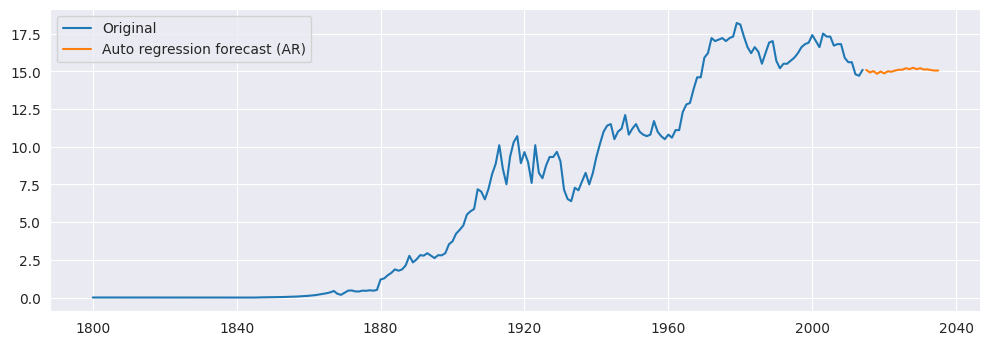

In [51]:
model = ARIMA(data, order=(4, 1, 4))
model_fit = model.fit()
forecast = pd.DataFrame()
forecast['arima_forecast'] = model_fit.predict(start = 215, end = 235)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['CO2'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

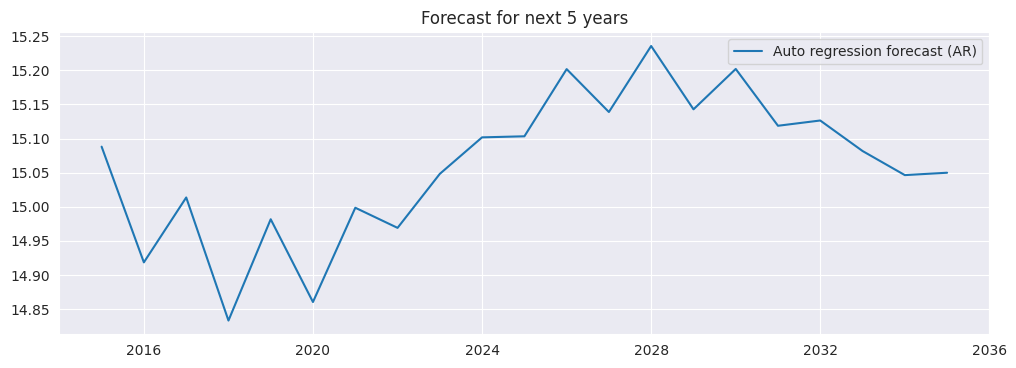

In [52]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 5 years')
plt.legend(loc='best')
plt.show()

In [53]:
forecast

,arima_forecast
2015-01-01,15.088136
2016-01-01,14.918452
2017-01-01,15.013631
2018-01-01,14.833128
2019-01-01,14.981687
2020-01-01,14.860315
2021-01-01,14.998557
2022-01-01,14.969046
2023-01-01,15.048234
2024-01-01,15.101777


# Deploying the Model

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore")

In [55]:
import pandas as pd 
from datetime import datetime


def dateparse(dates):
    return datetime.strptime(dates, '%Y')


data = pd.read_excel("CO2_dataset.xlsx",
                           parse_dates=['Year'],
                           index_col='Year',
                           date_parser=dateparse)

Creating new dataframe with user input

In [69]:
df = 22

In [70]:
future_dates=[data.index[-1]+ DateOffset(years=x)for x in range(0,df)]

In [71]:
future_data=pd.DataFrame(index=future_dates[1:],columns=data.columns)

Model building with arima

In [72]:
model = ARIMA(data['CO2'],order = (4,1,4))
final_arima = model.fit()

In [73]:
final_arima.fittedvalues.tail()

Year
2010-01-01    15.962540
2011-01-01    15.424614
2012-01-01    15.589866
2013-01-01    14.681912
2014-01-01    14.704074
dtype: float64

In [74]:
future_data['CO2'] = final_arima.predict(start = 215, end = 235, dynamic= True)  
#future_df[['CO2', 'forecast']].plot(figsize=(12, 8))
#plt.title('Forecast for next 5 years')

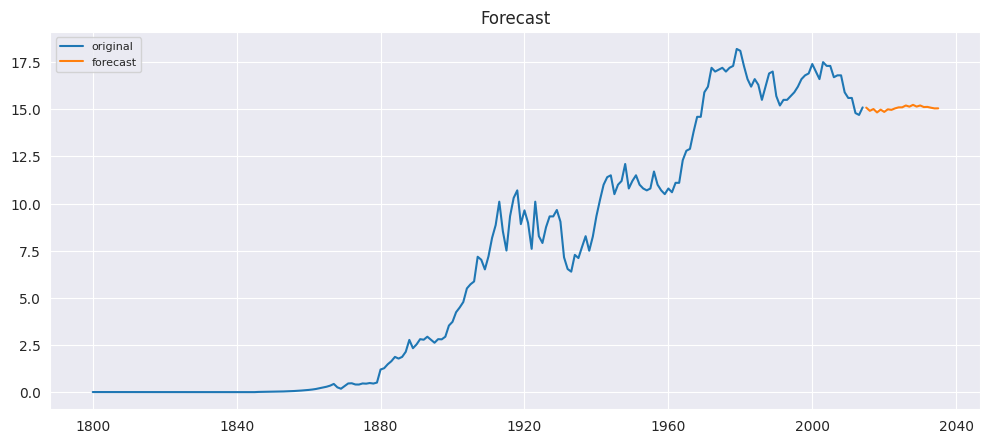

In [75]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data, label='original')
#plt.plot(test, label='actual')
plt.plot(future_data['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [76]:
future_data.tail(df)

,CO2
2015-01-01,15.088136
2016-01-01,14.918452
2017-01-01,15.013631
2018-01-01,14.833128
2019-01-01,14.981687
2020-01-01,14.860315
2021-01-01,14.998557
2022-01-01,14.969046
2023-01-01,15.048234
2024-01-01,15.101777
